In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np

import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder, Generate
import pandas as pd

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
import bionty as bt
import ot

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [ ]:
# ! uv pip install POT

In [2]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/"# "./normalize_log/"

# another one (human mouse)

In [ ]:
len(set(human.var.index) & set(mouse.var.index.str.upper()))

13090

In [3]:
human = sc.read(LOC+"task4_human.h5ad")
mouse = sc.read(LOC+"task4_mouse.h5ad")

In [4]:
def revert_to_raw(adata):
    res = adata.X
    res = np.exp(res) - 1
    res = (
        (res.T / np.array([res[i][res[i] != 0].min() for i in range(res.shape[0])]))
        .round()
        .T
    )  # .sum()
    adata.X = res
    return adata

In [6]:
human.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
mouse.obs["organism_ontology_term_id"] = "NCBITaxon:10090"

In [7]:
mouse = revert_to_raw(mouse)
human = revert_to_raw(human)

In [5]:
mouse.var.index = mouse.var.index.str.upper()
human = human[:, human.var.index.isin(mouse.var.index)]
mouse = mouse[:, mouse.var.index.isin(human.var.index)]

In [8]:
sc.pp.highly_variable_genes(human, n_top_genes=5000, flavor='seurat_v3')

In [9]:
hvg = human.var.index[human.var.highly_variable]

In [10]:
human = human[:, human.var.index.isin(hvg)]
mouse = mouse[:, mouse.var.index.isin(hvg)]

In [22]:
human.X.shape[0], mouse.X.shape[0]

(52816, 31474)

In [18]:
rand = np.random.choice(min(human.X.shape[0], mouse.X.shape[0]), size=2000, replace=False)

In [ ]:
res = ot.solve_sample(torch.Tensor(human.X[rand]), torch.Tensor(mouse.X[rand]), reg=0.1)
res.value

In [ ]:
200: 4.5, 6800
1000: 24.3, 5700
2000: 58s, 6300 (0.2 reg makes it longer 140s 5900)
20x = 40x ~40mn (120mn for 0.2 reg)

In [ ]:
human.X = scipy.sparse.csr_matrix(human.X)
mouse.X = scipy.sparse.csr_matrix(mouse.X)

In [ ]:
preprocessor = Preprocessor(
    is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False
)
human = preprocessor(human.copy())
mouse = preprocessor(mouse.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 52816 renamining
filtered out 5 cells, 52811 renamining
Removed 4285 genes not known to the ontology
Removed 0 duplicate genes
Added 53430 genes in the ontology but not present in the dataset
starting QC
Seeing 5700 outliers (10.79% of total dataset):
done
AnnData object with n_obs × n_vars = 52811 × 70116
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism

In [9]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
    "Proximal tubule cellAscending loop of Henle": "CL:1000909",
    "Intercalated cells of collecting duct": "CL:0005010",
    "Erythroid cell": "CL:0000764",
    "Microglia": "CL:0000129",
    "Distal convoluted tubule": "CL:1000849",
    "Connecting tubule cell": "CL:1000768",
}

res = (
    bt.CellType.standardize(
        mouse.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Macrophage': 'CL:0000235',
 'Astrocyte': 'CL:0000127',
 'Oligodendrocyte': 'CL:0000128',
 'Epithelial cell': 'CL:0000066',
 'Dendritic cell': 'CL:0000451',
 'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Neutrophil': 'CL:0000775',
 'Hepatocyte': 'CL:0000182',
 'Plasma cell': 'CL:0000786',
 'Cardiomyocyte': 'CL:0000746',
 'Neural progenitor cell': 'CL:0011020',
 'Erythroblast': 'CL:0000765',
 'Mast cell': 'CL:0000097',
 'Ependymal cell': 'CL:0000065',
 'Mesenchymal cell': 'CL:0008019',
 'Basal cell': 'CL:0000646',
 'Myocyte': 'CL:0000187',
 'Enterocyte': 'CL:0000584',
 'Unknown': 'unknown',
 'Megakaryocyte': 'CL:0000556',
 'Chondrocyte': 'CL:0000138',
 'Goblet cell': 'CL:0000160',
 'Striated muscle cell': 'CL:0000737',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': '

In [10]:
mouse.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in mouse.obs["celltype"].values
]

In [11]:
additional = {
    "Loop of Henle": "CL:1000909",
    "Sinusoidal endothelial cell ": "CL:0002262",
    "Endothelial cell (APC)": "CL:0000115",
    "stromal cell": "CL:0000499",
    "Epithelial cell (intermediated)": "CL:0000066",
}

res = (
    bt.CellType.standardize(
        human.obs.celltype.value_counts().keys(),
        return_mapper=True,
        return_field="ontology_id",
    )
    | additional
)
res

{'Smooth muscle cell': 'CL:0000192',
 'Monocyte': 'CL:0000576',
 'Epithelial cell': 'CL:0000066',
 'Intercalated cell': 'CL:0005010',
 'Macrophage': 'CL:0000235',
 'Dendritic cell': 'CL:0000451',
 'Stromal cell': 'CL:0000499',
 'Neutrophil': 'CL:0000775',
 'Mast cell': 'CL:0000097',
 'Fibroblast': 'CL:0000057',
 'Endothelial cell': 'CL:0000115',
 'Ureteric bud cell': 'CL:4030066',
 'Goblet cell': 'CL:0000160',
 'Myeloid cell': 'CL:0000763',
 'Stratified epithelial cell': 'CL:0000079',
 'Basal cell': 'CL:0000646',
 'T cell': 'CL:0000084',
 'B cell': 'CL:0000236',
 'Loop of Henle': 'CL:1000909',
 'Sinusoidal endothelial cell ': 'CL:0002262',
 'Endothelial cell (APC)': 'CL:0000115',
 'stromal cell': 'CL:0000499',
 'Epithelial cell (intermediated)': 'CL:0000066'}

In [12]:
human.obs["cell_type_ontology_term_id"] = [
    res.get(i, "unknown") for i in human.obs["celltype"].values
]


In [13]:
human.write(LOC+"proc_hum.h5ad")
mouse.write(LOC+"proc_mouse.h5ad")

... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


In [24]:
human = sc.read(LOC+"proc_hum.h5ad")
mouse = sc.read(LOC+"proc_mouse.h5ad")

## re-generate those cell types with mouse genes and compare

In [25]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/ji9krimq.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [26]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


In [7]:
human

AnnData object with n_obs × n_vars = 52811 × 70116
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'cell_type_ontology_term_id'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [27]:
embed = Embedder(
    how="random expr",
    max_len=2600,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
    save_every = 10_000,
)
n_adata, _ = embed(model, human[rand])

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


logging the anndata
AnnData object with n_obs × n_vars = 2000 × 20004
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_th

In [28]:
embed = Embedder(
    how="random expr",
    max_len=2600,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)
sup, _ = embed(model, mouse[rand])#np.random.choice(mouse.shape[0], 1000, replace=False)])

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


logging the anndata
AnnData object with n_obs × n_vars = 2000 × 21550
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_th

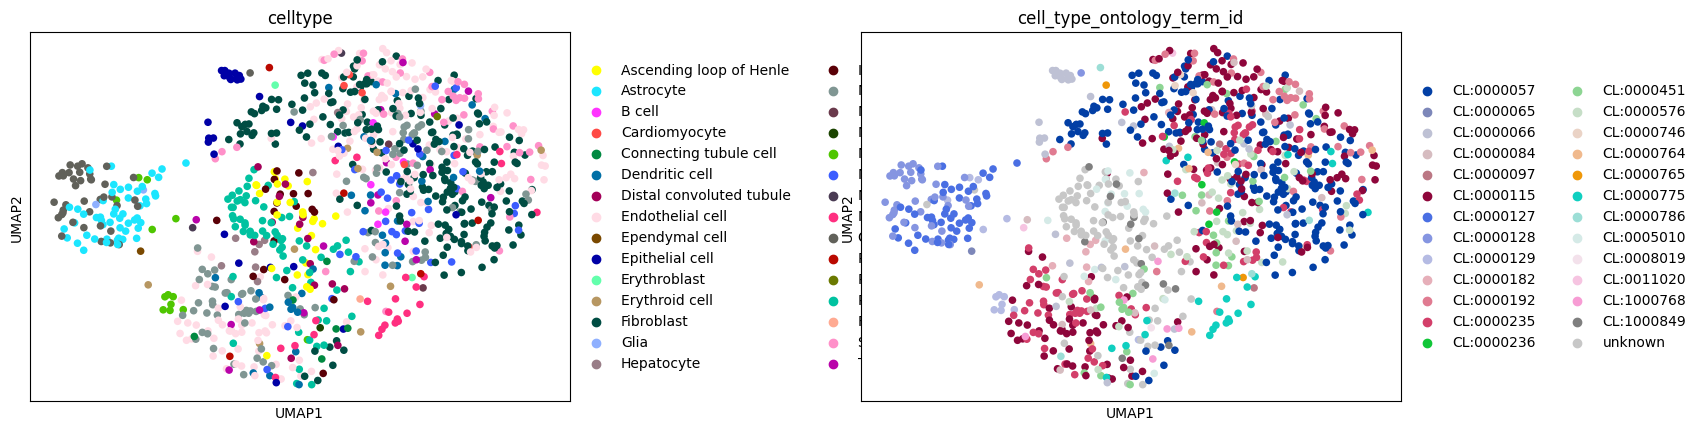

In [17]:
sc.pp.neighbors(sup, use_rep="scprint_emb_organism_ontology_term_id")
sc.tl.umap(sup)
sc.pl.umap(sup, color=["celltype", "cell_type_ontology_term_id"], wspace=0.4)

In [9]:
n_adata.obsm["scprint_emb_organism_ontology_term_id"] = np.tile(sup.obsm["scprint_emb_organism_ontology_term_id"].mean(0), (n_adata.shape[0], 1))

In [29]:
human = human[:, human.var.symbol.isin(mouse.var.symbol.str.upper()) & human.var.index.isin(model.genes)]

[autoreload of scprint.tasks.generate failed: Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/pasteur/appa/homes/jkalfon/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_remove

In [30]:
sc.pp.highly_variable_genes(human, n_top_genes=5000, flavor='seurat_v3')

In [44]:
genes = mouse.var.index[mouse.var.symbol.str.upper().isin(human.var.symbol[human.var['highly_variable']].tolist()) & mouse.var.index.isin(model.genes)].tolist()

In [46]:
len(genes)

4594

In [ ]:
# if it doesn't work, try with a much smaller dataset

In [ ]:
human = human[:, human.var.index.isin(genes)]
mouse = mouse[:, mouse.var.index.isin(genes)]

In [34]:
elems = [
    "scprint_emb_age_group", "scprint_emb_assay_ontology_term_id", "scprint_emb_cell_culture", "scprint_emb_cell_type_ontology_term_id", "scprint_emb_disease_ontology_term_id", "scprint_emb_organism_ontology_term_id", "scprint_emb_other", "scprint_emb_self_reported_ethnicity_ontology_term_id", "scprint_emb_sex_ontology_term_id", "scprint_emb_tissue_ontology_term_id"
]

[autoreload of scprint.tasks.generate failed: Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/pasteur/appa/homes/jkalfon/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_remove

In [49]:
generator = Generate(
    genelist=genes,
    batch_size=32
)

In [64]:
pred = generator(model, n_adata)

not on wandb, could not set name


100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


In [68]:
mouse = mouse[:, mouse.var.index.isin(genes)]

In [69]:
mouse[rand]

View of AnnData object with n_obs × n_vars = 31474 × 4594
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'stage', 'celltype', 'cell_lineage', 'n_genes', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'cell_type_ontology_term_id'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [73]:
mouse[rand].X.sum(1).mean()

227.6045

In [75]:
human[rand].X.sum(1).mean()

234.922

In [74]:
# comparison
pred.X.sum(1).mean()

796.8215

In [77]:
res = ot.solve_sample(torch.Tensor(pred.X), torch.Tensor(mouse.X[rand].todense()), reg=0.1)
res.value

tensor(1586.4365)

In [81]:
toc = ad.concat([pred, mouse[rand]], label='organism')

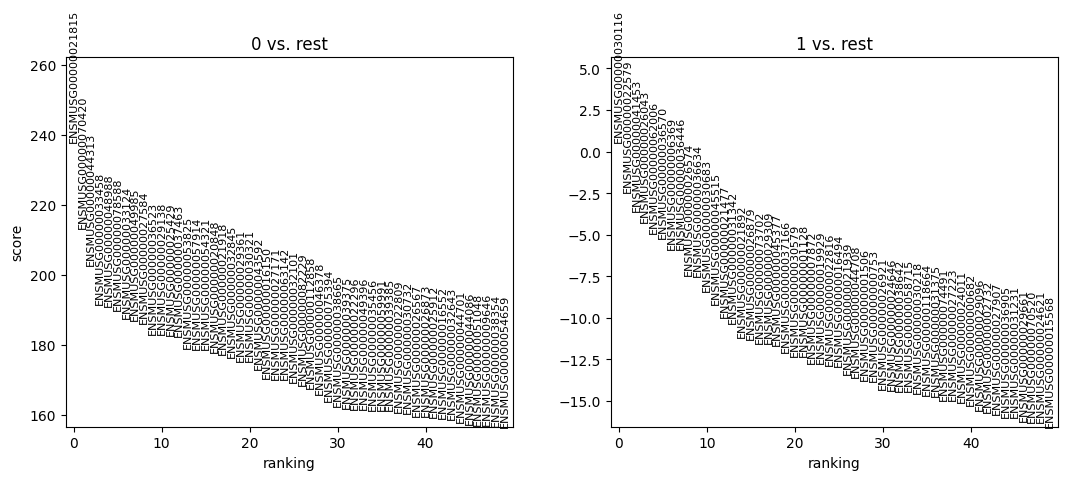

In [ ]:
# full diff expr
sc.pp.normalize_total(toc, target_sum=1e4)
sc.pp.log1p(toc)

In [92]:
toc.var.set_index('symbol', inplace=True)

KeyError: "None of ['symbol'] are in the columns"

In [ ]:
sc.tl.rank_genes_groups(toc, groupby='organism', method='t-test_overestim_var')


In [ ]:
toc.var

In [85]:
toc.var = mouse.var

In [91]:
toc.var

,n_cells,uid,biotype,organism_id,branch_id,mt,ribo,hb,organism,ensembl_gene_id,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSMUSG00000000028,211.0,2IgYexLtRNg8,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000028,211,0.007117,0.007092,99.329605,224.0,5.416101
ENSMUSG00000000049,395.0,u7T0dhlTR2C5,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000049,395,0.018396,0.018229,98.744996,579.0,6.363028
ENSMUSG00000000078,4169.0,30ZRk9TCBtV5,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000078,4169,0.174048,0.160458,86.754146,5478.0,8.608678
ENSMUSG00000000093,459.0,3ERF0n1O2kFv,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000093,459,0.015664,0.015542,98.541653,493.0,6.202536
ENSMUSG00000000154,892.0,3cND7avFQRKz,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000154,892,0.036316,0.035672,97.165915,1143.0,7.042286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000118541,NaN,7VnkEI3RYpAv,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000118541,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000118663,51.0,2zH38yukVJMl,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000118663,51,0.001620,0.001619,99.837961,51.0,3.951244
ENSMUSG00000118664,2159.0,2kfEKHl6Mut2,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000118664,2159,0.076952,0.074135,93.140370,2422.0,7.792762
ENSMUSG00000118667,346.0,4tK7p8v2KRwU,protein_coding,1,1,False,False,False,NCBITaxon:10090,ENSMUSG00000118667,346,0.011851,0.011781,98.900680,373.0,5.924256


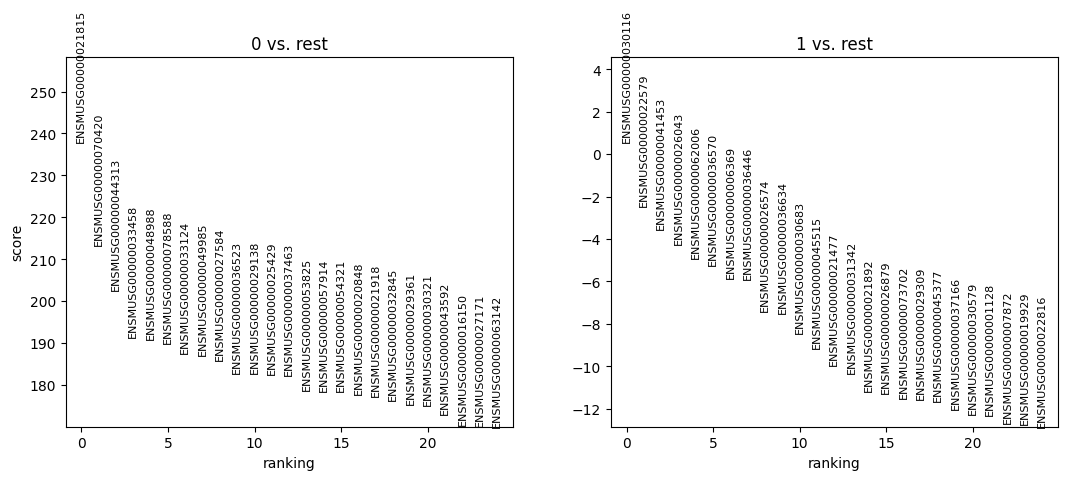

In [90]:
sc.pl.rank_genes_groups(toc, n_genes=25, sharey=False)

In [87]:
# show the df
toc.uns['rank_genes_groups']

{'params': {'groupby': 'organism',
  'reference': 'rest',
  'method': 't-test_overestim_var',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('ENSMUSG00000021815', 'ENSMUSG00000030116'),
            ('ENSMUSG00000070420', 'ENSMUSG00000022579'),
            ('ENSMUSG00000044313', 'ENSMUSG00000041453'), ...,
            ('ENSMUSG00000041453', 'ENSMUSG00000044313'),
            ('ENSMUSG00000022579', 'ENSMUSG00000070420'),
            ('ENSMUSG00000030116', 'ENSMUSG00000021815')],
           dtype=[('0', 'O'), ('1', 'O')]),
 'scores': rec.array([(237.86188   ,    0.55221736), (213.32414   ,   -2.433148  ),
            (202.60178   ,   -3.5581672 ), ...,
            (  3.5581672 , -202.60178   ), (  2.433148  , -213.32414   ),
            ( -0.55221736, -237.86188   )],
           dtype=[('0', '<f4'), ('1', '<f4')]),
 'pvals': rec.array([(0.00000000e+00, 5.80849020e-01),
            (0.00000000e+00, 1.50382890e-02),
            (0.00000000

In [ ]:
enr = gp.prerank(
    rnk=list(G.nodes),
    gene_sets=[
        "Reactome_2022"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=mouse.var.index.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.0].head(20)

In [ ]:
# diff expr analysis

## now generate them in female

In [ ]:
# diff expr analysis

## now in cancer

In [ ]:
# diff expr analysis